# **Face Landmark Detection with dlib Class**


---


### **Overview**

This module demonstrates how to detect **68 facial landmarks** using `dlib`. These landmarks include key facial features like:

* Eyes
* Eyebrows
* Nose
* Mouth
* Jawline

---

### **Requirements**

* Python ≥ 3.6
* `opencv-python`
* `dlib`
* [Pretrained 68-landmark model](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)

Unzip the `.bz2` file and use `shape_predictor_68_face_landmarks.dat`.

---


## **Face Landmark Detector Class**


In [1]:
import cv2
import dlib
import numpy as np


class FaceLandmarkDetector:
    """
    A class for detecting 68 facial landmarks using dlib's pre-trained models.

    This class provides functionality to:
    - Detect faces in an image using HOG + SVM
    - Predict 68 facial landmarks for each face
    - Optionally draw connections between landmarks or just points
    - Draw bounding boxes around detected faces
    - Compute distances between specific landmark points
    """

    # Facial landmark indexes (based on dlib's 68-point shape predictor)
    FACIAL_LANDMARKS_IDXS = {
        "jaw": (0, 17),
        "right_eyebrow": (17, 22),
        "left_eyebrow": (22, 27),
        "nose": (27, 36),
        "right_eye": (36, 42),
        "left_eye": (42, 48),
        "outer_mouth": (48, 60),
        "inner_mouth": (60, 68),
    }

    def __init__(self, model_path: str = "shape_predictor_68_face_landmarks.dat"):
        """
        Initializes the FaceLandmarkDetector class.

        Args:
            model_path (str): Path to the pre-trained dlib 68-point facial landmark model.
        """
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor(model_path)

    def detect_landmarks(
        self,
        image: np.ndarray,
        draw_connections: bool = False,
        draw_points: bool = False,
        draw_rect: bool = False,
    ) -> list:
        """
        Detects facial landmarks in an image and optionally draws them.

        Args:
            image (np.ndarray): The input BGR image.
            draw_connections (bool): Whether to draw lines between connected landmark points.
            draw_points (bool): Whether to draw landmark points as circles.
            draw_rect (bool): Whether to draw a bounding box around each detected face.

        Returns:
            List of np.ndarray: Each array is shape (68, 2) representing landmark coordinates for one face.
        """
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_faces = self.face_detector(gray_image)

        all_faces_landmarks = []

        for face in detected_faces:
            landmarks = self.landmark_predictor(gray_image, face)
            landmark_points = np.zeros((68, 2), dtype=int)

            for i in range(68):
                landmark_points[i] = (landmarks.part(i).x, landmarks.part(i).y)
            all_faces_landmarks.append(landmark_points)

            if draw_connections:
                self._draw_landmark_connections(image, landmark_points)
            if draw_points:
                self._draw_landmark_points(image, landmark_points)
            if draw_rect:
                self._draw_bounding_box(image, face)

        return all_faces_landmarks

    def _draw_landmark_connections(self, image: np.ndarray, points: np.ndarray):
        """
        Draws lines connecting facial landmark points based on facial regions.

        Args:
            image (np.ndarray): The image on which to draw.
            points (np.ndarray): Array of landmark points (shape: 68, 2).
        """
        colors = [
            (255, 255, 0),  # jaw
            (0, 255, 255),  # right eyebrow
            (0, 255, 255),  # left eyebrow
            (0, 255, 0),  # nose
            (0, 0, 255),  # right eye
            (0, 0, 255),  # left eye
            (0, 255, 0),  # outer mouth
            (0, 255, 0),  # inner mouth
        ]

        for i, (start, end) in enumerate(self.FACIAL_LANDMARKS_IDXS.values()):
            isClosed = i >= 4  # close eye and mouth regions
            cv2.polylines(image, [points[start:end]], isClosed, colors[i], 2)

    def _draw_landmark_points(self, image: np.ndarray, points: np.ndarray):
        """
        Draws small circles for each facial landmark point.

        Args:
            image (np.ndarray): The image on which to draw.
            points (np.ndarray): Array of landmark points (shape: 68, 2).
        """
        for x, y in points:
            cv2.circle(image, (x, y), 2, (0, 0, 255), -1)

    def _draw_bounding_box(self, image: np.ndarray, face: dlib.rectangle):
        """
        Draws a bounding box around the detected face.

        Args:
            image (np.ndarray): The image on which to draw.
            face (dlib.rectangle): The rectangle representing the face.
        """
        x1, y1 = face.left(), face.top()
        x2, y2 = face.right(), face.bottom()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    @staticmethod
    def calculate_distance(point1: tuple, point2: tuple) -> float:
        """
        Calculates the Euclidean distance between two 2D points.

        Args:
            point1 (tuple): First point (x, y).
            point2 (tuple): Second point (x, y).

        Returns:
            float: Euclidean distance.
        """
        return np.linalg.norm(np.array(point1) - np.array(point2))

---


### **1. Example: Static Image**


In [2]:
import cv2

image = cv2.imread("../images/faces.jpg")
detector = FaceLandmarkDetector("../models/shape_predictor_68_face_landmarks.dat")

detector.detect_landmarks(
    image,
    draw_connections=True,
    draw_points=True,
    draw_rect=True,
)

cv2.imshow("Facial Landmarks", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### **2. Example: Live Webcam Feed**


In [3]:
import cv2

# Start video capture
cap = cv2.VideoCapture(0)

# Initialize the landmark detector
detector = FaceLandmarkDetector("../models/shape_predictor_68_face_landmarks.dat")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Flip horizontally for mirror view

    # Detect and draw landmarks
    faces = detector.detect_landmarks(
        frame, draw_connections=True, draw_points=False, draw_rect=True
    )

    # Example: measure eye height between two points (e.g. between eyebrow and eye)
    if faces:
        for face_landmarks in faces:
            point1 = face_landmarks[19]  # Upper part of left eyebrow
            point2 = face_landmarks[41]  # Lower part of left eye
            distance = detector.calculate_distance(point1, point2)

            # Draw distance as text
            cv2.putText(
                frame,
                f"Eye Height: {distance:.2f}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 0, 0),
                2,
            )

    # Display the result
    cv2.imshow("Live Face Landmark Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

---


## **Facial Landmark Map**

| Facial Region | Index Range |
| ------------- | ----------- |
| Jawline       | 0–16        |
| Right eyebrow | 17–21       |
| Left eyebrow  | 22–26       |
| Nose          | 27–35       |
| Right eye     | 36–41       |
| Left eye      | 42–47       |
| Outer mouth   | 48–59       |
| Inner mouth   | 60–67       |

---


## **Images**


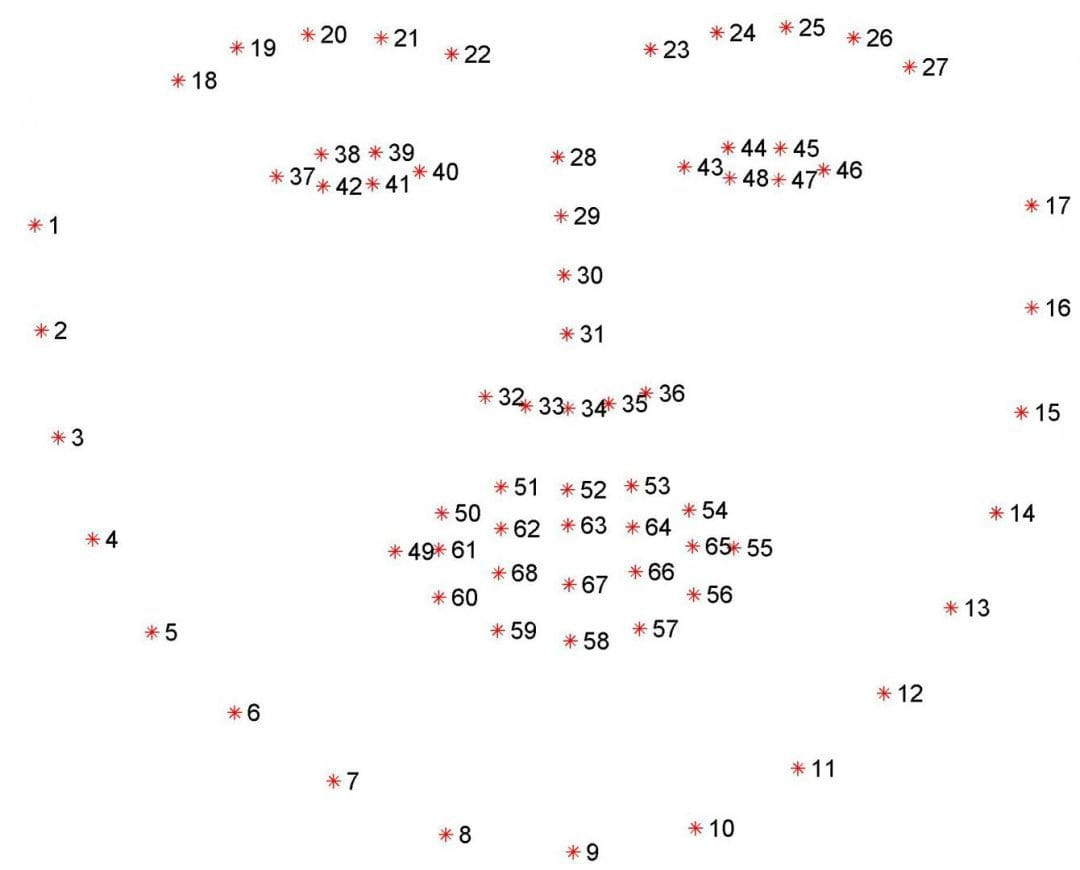


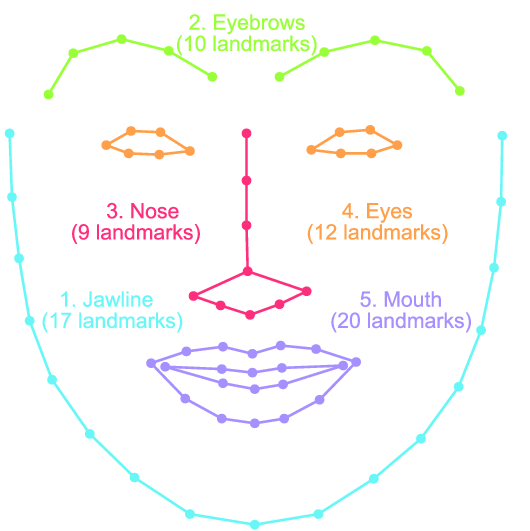


---
